In [2]:
import numpy as np
import pandas as pd
import os
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from scipy import stats
register_matplotlib_converters()


##### Importing Data 
We import data in a dictionary containing a dataframe for each day

In [3]:
## list the files in the directory
data_files_list = os.listdir("Data/Data/RENA.PA/")
data_files_list = [f for f in data_files_list if "trades" in f]
## import each day as a pandas DF in a dictionary
data_dict = {i : pd.read_csv("Data/Data/RENA.PA/"+f) for i,f in zip(range(len(data_files_list)),data_files_list) }

In [4]:
### Convert timestams into pd.datetime
for _, df in data_dict.items():
    df['ts'] = pd.to_datetime(df["ts"])

### Question I

##### 1.
We want to plot the evolution of the transaction price on the fulle sample

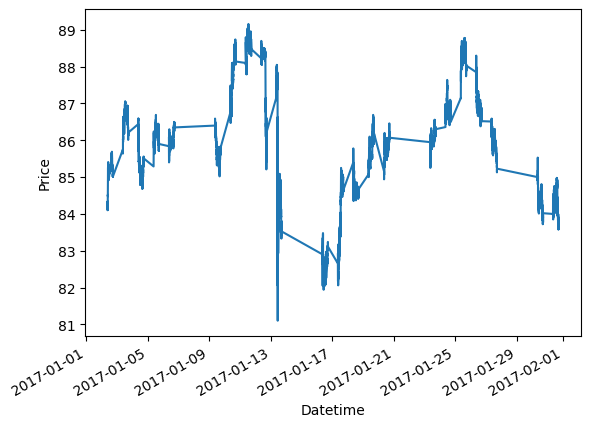

In [55]:
data_total = pd.concat(data_dict,axis = 0).drop(['Unnamed: 0'],axis = 1)
fig ,ax = plt.subplots()
ax.plot(data_total.ts,data_total.price)
fig.autofmt_xdate()
ax.set_xlabel('Datetime')
ax.set_ylabel('Price')
plt.show()


##### 2.
We plot the price on a subset of a few minutes (10 minutes from the beginning of the sample)

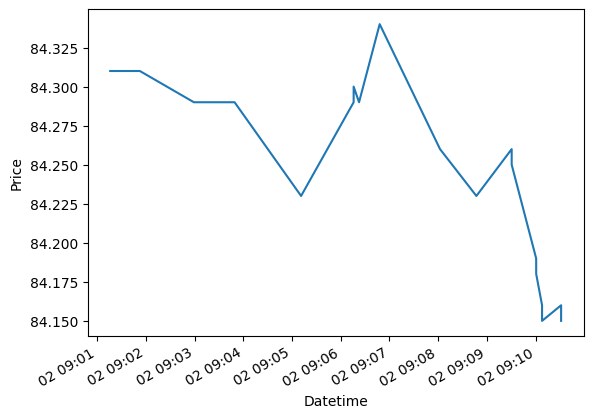

In [56]:
min_subsample= data_total.loc[data_total.ts < (data_total.ts.iloc[0] + pd.DateOffset(minutes= 10))]
fig ,ax = plt.subplots()
ax.plot(min_subsample.ts,min_subsample.price)
fig.autofmt_xdate()
ax.set_xlabel('Datetime')
ax.set_ylabel('Price')
plt.show()

plt.show()

##### 3. 
We want to measure the ticksize. To do this we extract the minimum price movement observed in the series, this will likely be sufficient to extract the minimum movement in price.

In [57]:
tick= data_total.price.sort_values().diff()
tick = tick[tick>0].min()
tick

0.009999999999990905

This corresponds approximately to the tick of 0.01 in the euronext trading rules.

### Question 2

##### 1.
We want to plot the number of trades per day and it's mean on the sample

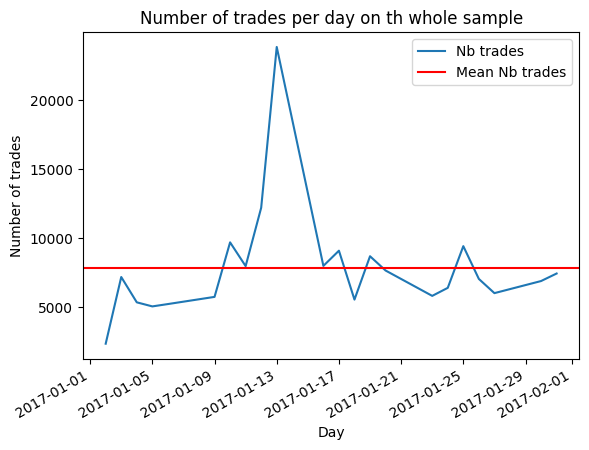

In [58]:
day_trades = data_total.groupby(data_total.ts.dt.date).count()
fig ,ax = plt.subplots()
ax.plot(day_trades.index,day_trades.ts)
fig.autofmt_xdate()
ax.set_xlabel('Day')
ax.set_ylabel('Number of trades')
plt.axhline(y=day_trades.ts.mean(), color='r', linestyle='-')
plt.legend(["Nb trades","Mean Nb trades"])
plt.title('Number of trades per day on th whole sample')
plt.show()



##### 2.
For each day of the subsample we compute the number of trades per bin of 1 min, then the mean and the median on all days 

In [133]:
nb_trades_1minute = {i : df.set_index('ts').resample('1T').count()\
    ["volume"] for i,df in data_dict.items()}

nb_trades_1minute
### This is the number of trades with an interval of 1 min for each day, we filled in the minutes where no trades were made

{0: ts
 2017-01-02 09:01:00     5
 2017-01-02 09:02:00     2
 2017-01-02 09:03:00     1
 2017-01-02 09:04:00     0
 2017-01-02 09:05:00     1
                        ..
 2017-01-02 17:25:00    14
 2017-01-02 17:26:00    16
 2017-01-02 17:27:00    20
 2017-01-02 17:28:00     8
 2017-01-02 17:29:00    36
 Freq: T, Name: volume, Length: 509, dtype: int64,
 1: ts
 2017-01-03 09:00:00     9
 2017-01-03 09:01:00    21
 2017-01-03 09:02:00     4
 2017-01-03 09:03:00    15
 2017-01-03 09:04:00     4
                        ..
 2017-01-03 17:25:00    27
 2017-01-03 17:26:00    24
 2017-01-03 17:27:00     6
 2017-01-03 17:28:00    42
 2017-01-03 17:29:00    30
 Freq: T, Name: volume, Length: 510, dtype: int64,
 2: ts
 2017-01-04 09:00:00     2
 2017-01-04 09:01:00     0
 2017-01-04 09:02:00    56
 2017-01-04 09:03:00    12
 2017-01-04 09:04:00     7
                        ..
 2017-01-04 17:25:00    19
 2017-01-04 17:26:00    17
 2017-01-04 17:27:00    36
 2017-01-04 17:28:00    22
 2017-01-04 1

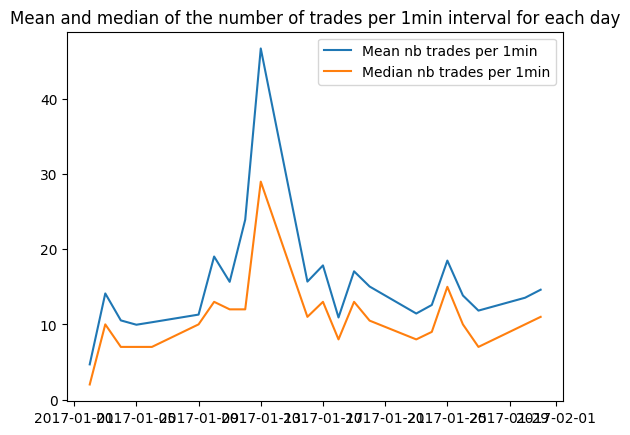

In [136]:
## now we want to plot the mean and the median per day
mean_per_day = np.array([df.mean() for df in nb_trades_1minute.values()])
median_per_day = np.array([df.median() for df in nb_trades_1minute.values()])


## we then plot these quantities per day
plt.plot(data_total.ts.dt.date.unique(),mean_per_day) 
plt.plot(data_total.ts.dt.date.unique(),median_per_day)
plt.legend(["Mean nb trades per 1min","Median nb trades per 1min"])
plt.title('Mean and median of the number of trades per 1min interval for each day')
plt.show()

##### 3.

here we observe that the median is at zero which is not surprizing given 
that half the day contains no trades but the mean is non zero exctept on weekends. We also observe the mean of trades per minute is maximum increases in the beginning of the week and decreses at the end of the week.

### Question3


1.
Plot of the empirical density of trade durations

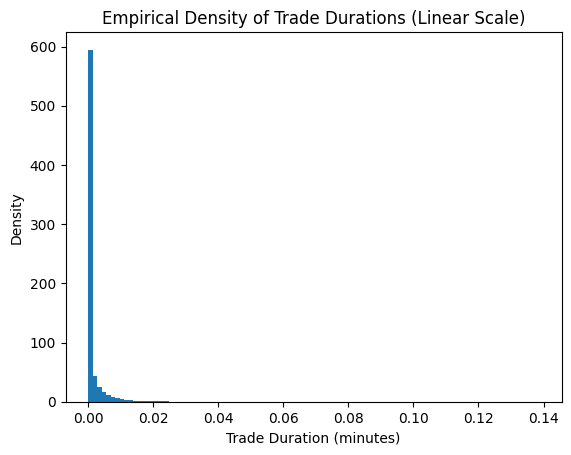

In [145]:
# calculate the trade durations
trade_durations = pd.concat([(df['ts'].diff().dropna() / pd.Timedelta(hours=1)) for df in data_dict.values()])
trade_durations

## plot the density in linear scale
plt.hist(trade_durations, bins=100, density=True)
plt.title('Empirical Density of Trade Durations (Linear Scale)')
plt.xlabel('Trade Duration (minutes)')
plt.ylabel('Density')
plt.show()

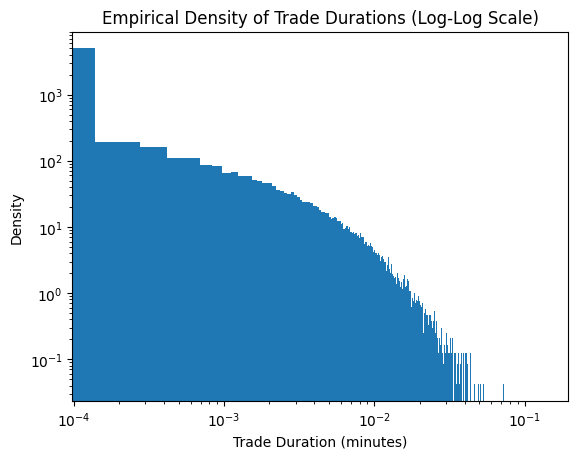

In [153]:
# plot the same density in log-log scale
plt.hist(trade_durations, bins=1000, density=True,log = True)
plt.xscale('log')
plt.title('Empirical Density of Trade Durations (Log-Log Scale)')
plt.xlabel('Trade Duration (minutes)')
plt.ylabel('Density')
plt.show()

##### 2.
We add an exponential fit to the histogrames

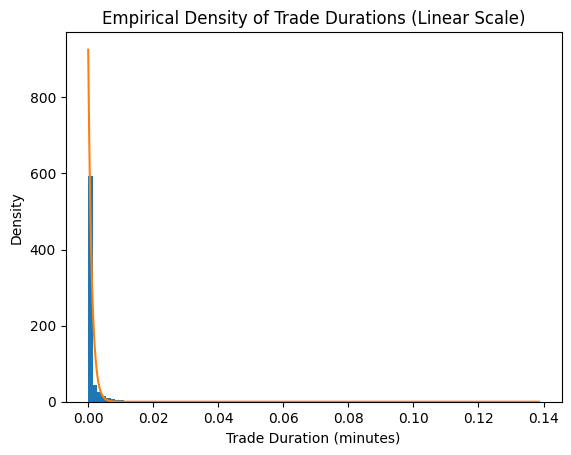

In [175]:
exp_fit = stats.expon.fit(trade_durations)
exp_law = stats.expon(*exp_fit)
pdf = exp_law.pdf(np.sort(trade_durations))
## plot the density in linear scale
plt.hist(trade_durations, bins=100, density=True)
plt.plot(np.sort(trade_durations),pdf)
plt.title('Empirical Density of Trade Durations (Linear Scale)')
plt.xlabel('Trade Duration (minutes)')
plt.ylabel('Density')
plt.show()


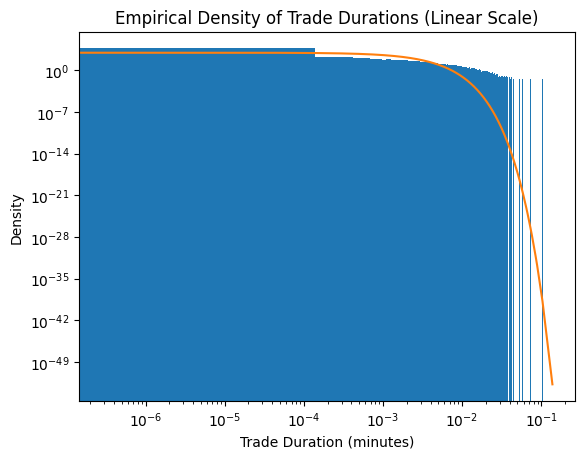

In [179]:
## plot the density in log-log scale
plt.hist(trade_durations, bins=1000, density=True, log = True)
plt.plot(np.sort(trade_durations),pdf)
plt.xscale('log')
plt.title('Empirical Density of Trade Durations (Linear Scale)')
plt.xlabel('Trade Duration (minutes)')
plt.ylabel('Density')
plt.show()


##### 3.
This comment means given the densities of the two laws that a powerlaw is more appropriate for the log of the duration. This can be checked by looking at the law of $log(X)$ when $X\sim\mathcal{E}(\lambda)$

### Question 4

##### 1.
we plot a histogram of the empirical density of trade size

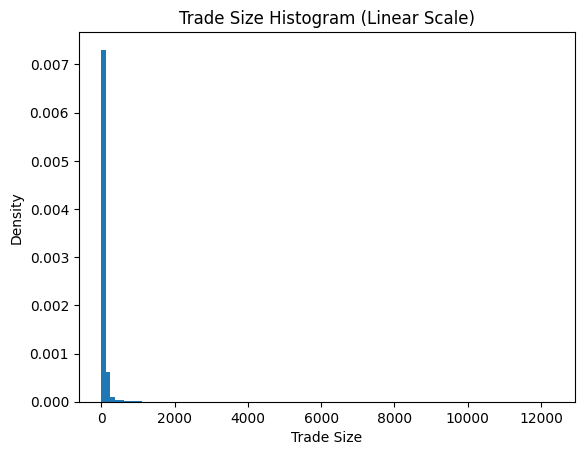

In [180]:
# PLot in linear scale
plt.hist(data_total.volume, bins=100, density=True)
plt.title('Trade Size Histogram (Linear Scale)')
plt.xlabel('Trade Size')
plt.ylabel('Density')
plt.show()

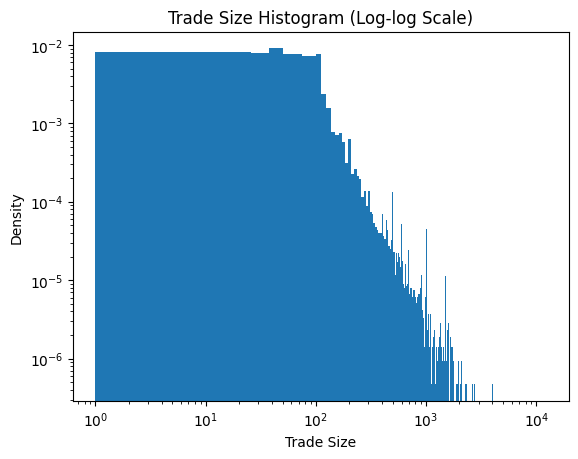

In [183]:
# PLot in log-log scale
plt.hist(data_total.volume, bins=1000, density=True,log = True)
plt.xscale('log')
plt.title('Trade Size Histogram (Log-log Scale)')
plt.xlabel('Trade Size')
plt.ylabel('Density')
plt.show()

##### 2.
We add an exponential fit to the log-log histogram

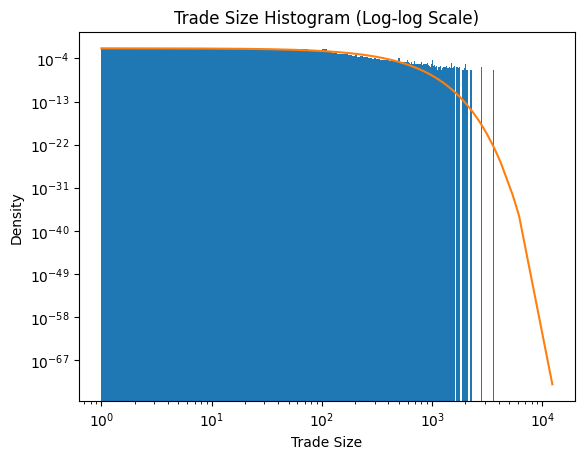

In [184]:
exp_fit = stats.expon.fit(data_total.volume)
exp_law = stats.expon(*exp_fit)
pdf = exp_law.pdf(np.sort(data_total.volume))
plt.hist(data_total.volume, bins=1000, density=True,log = True)
plt.plot(np.sort(data_total.volume), pdf)
plt.xscale('log')
plt.title('Trade Size Histogram (Log-log Scale)')
plt.xlabel('Trade Size')
plt.ylabel('Density')
plt.show()

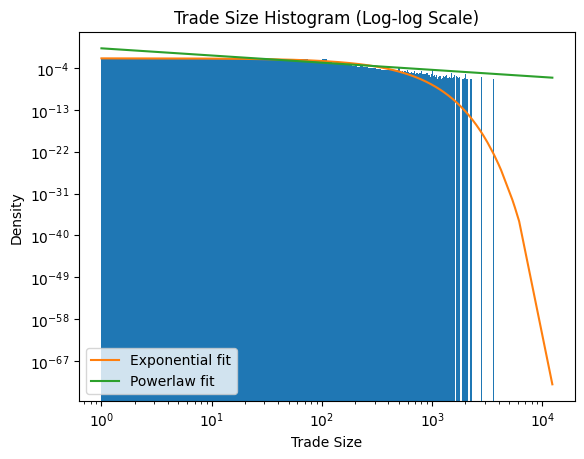

In [187]:
import powerlaw
fit = powerlaw.Fit(data_total.volume, discrete=True)
alpha = fit.alpha
xmin = fit.xmin
y = (alpha-1)/xmin * (np.sort(data_total.volume.values)/xmin)**(-alpha)
plt.hist(data_total.volume, bins=1000, density=True,log = True)
plt.plot(np.sort(data_total.volume), pdf)
plt.plot(np.sort(data_total.volume), y)
plt.legend(["Exponential fit","Powerlaw fit"])
plt.xscale('log')
plt.title('Trade Size Histogram (Log-log Scale)')
plt.xlabel('Trade Size')
plt.ylabel('Density')
plt.show()

### Question 5

##### 1.
Plotting the complementary cumulative empirical distribution function of the absolute log-returns
sampled every 1, 5 and 15 minutes

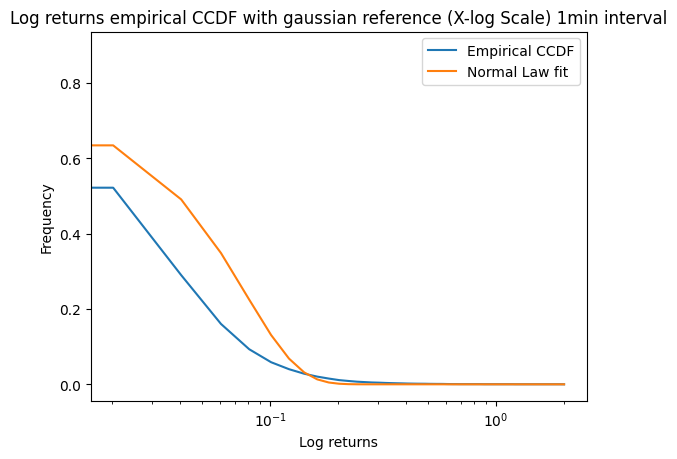

In [230]:
import statsmodels.api as sm
normal= stats.norm
period = 1
abs_log_returns = {i : df.set_index('ts').loc[:,["price"]].resample(f'{period}min').last()\
                   .diff().dropna().abs() for i,df in data_dict.items()}

observations = np.concatenate([df.price for df in abs_log_returns.values()])
# ccdf calculation
ecdf = sm.distributions.ECDF(observations)
x_vals = np.linspace(np.min(observations), np.max(observations), 100)
ccdf = 1- ecdf(x_vals)

normal_fit = normal.fit(observations)
normal_law = normal(*normal_fit)
normal_y = 1-normal_law.cdf(x_vals)


plt.plot(x_vals, ccdf)
plt.plot(x_vals, normal_y)
plt.xscale('log')
plt.legend(["Empirical CCDF","Normal Law fit"])
plt.title('Log returns empirical CCDF with gaussian reference (X-log Scale) 1min interval')
plt.xlabel('Log returns')
plt.ylabel('Frequency')
plt.show()


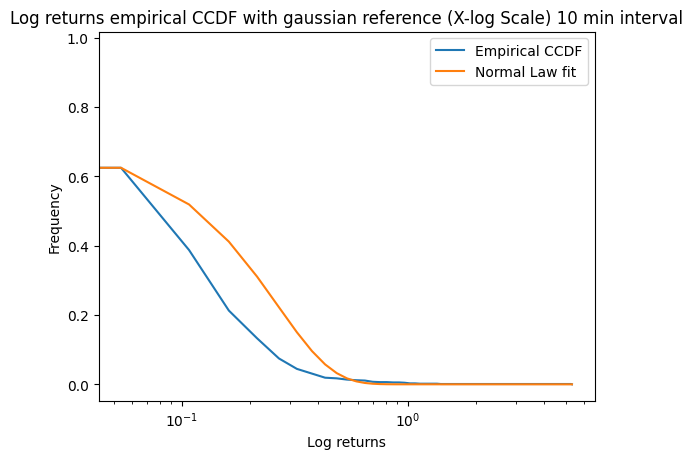

In [229]:
period = 10
abs_log_returns = {i : df.set_index('ts').loc[:,["price"]].resample(f'{period}min').last()\
                   .diff().dropna().abs() for i,df in data_dict.items()}

observations = np.concatenate([df.price for df in abs_log_returns.values()])
# ccdf calculation
ecdf = sm.distributions.ECDF(observations)
x_vals = np.linspace(np.min(observations), np.max(observations), 100)
ccdf = 1- ecdf(x_vals)

normal_fit = normal.fit(observations)
normal_law = normal(*normal_fit)
normal_y = 1-normal_law.cdf(x_vals)


plt.plot(x_vals, ccdf)
plt.plot(x_vals, normal_y)
plt.xscale('log')
plt.legend(["Empirical CCDF","Normal Law fit"])
plt.title('Log returns empirical CCDF with gaussian reference (X-log Scale) 10 min interval')
plt.xlabel('Log returns')
plt.ylabel('Frequency')
plt.show()

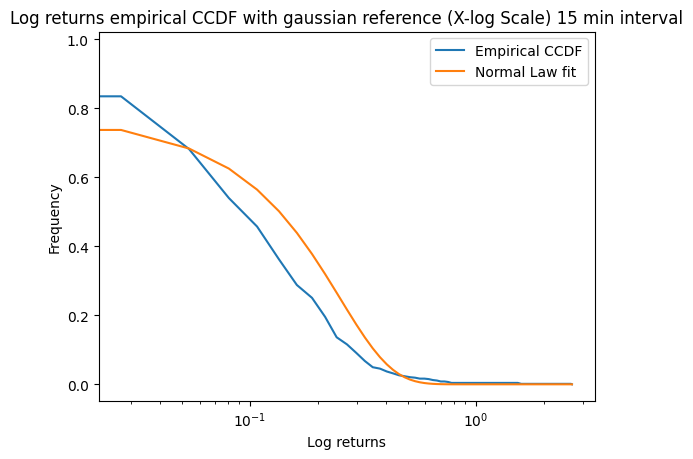

In [231]:
period = 15
abs_log_returns = {i : df.set_index('ts').loc[:,["price"]].resample(f'{period}min').last()\
                   .diff().dropna().abs() for i,df in data_dict.items()}

observations = np.concatenate([df.price for df in abs_log_returns.values()])
# ccdf calculation
ecdf = sm.distributions.ECDF(observations)
x_vals = np.linspace(np.min(observations), np.max(observations), 100)
ccdf = 1- ecdf(x_vals)

normal_fit = normal.fit(observations)
normal_law = normal(*normal_fit)
normal_y = 1-normal_law.cdf(x_vals)


plt.plot(x_vals, ccdf)
plt.plot(x_vals, normal_y)
plt.xscale('log')
plt.legend(["Empirical CCDF","Normal Law fit"])
plt.title('Log returns empirical CCDF with gaussian reference (X-log Scale) 15 min interval')
plt.xlabel('Log returns')
plt.ylabel('Frequency')
plt.show()

The returns seem to have fatter tails than the gaussian distribution especially on the left hand side of the distribution which would justify the use of heavier tail distributions.